In [26]:
# see more styles and js code (linked at the bottom) at https://www.tylerxhobbs.com/words/flow-fields

In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_vector_field(grid, displacement):
    x = grid[:, 0].numpy()
    y = grid[:, 1].numpy()
    u = displacement[:, 0].numpy()
    v = displacement[:, 1].numpy()

    plt.figure(figsize=(5, 5))

    # color the vector field based on the magnitude of the displacement
    magnitude = np.sqrt(u**2 + v**2)
    plt.quiver(x, y, u, v, magnitude, cmap='viridis',
               angles='xy', scale_units='xy', scale=1, alpha=0.5)
    
    plt.xlim(np.min(x), np.max(x))
    plt.ylim(np.min(y), np.max(y))
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Vector Field')
    plt.grid()
    plt.show()

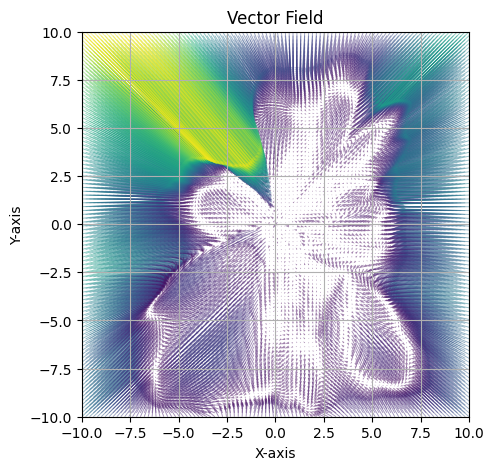

In [28]:
vfield = torch.load('data/vectorfield.pt')
grid = vfield['grid']
displacement=vfield['displacement']

plot_vector_field(grid, displacement)


Rendering LIC with loaded vector field...


generate lics: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]



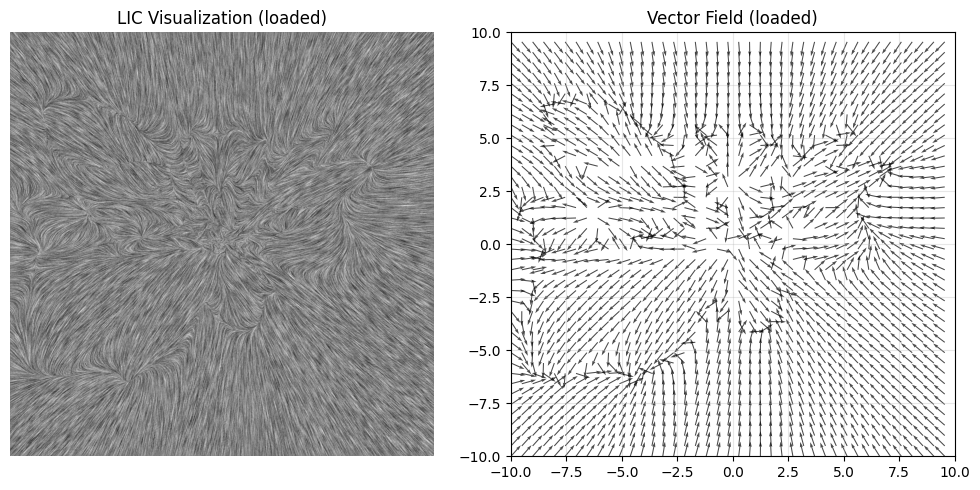

In [40]:
import numpy as np
import lic, matplotlib.pyplot as plt
from scipy.interpolate import griddata

def create_lic_visualization(mode='loaded', R=1.6, RES=1024, length=30):
    """
    Create LIC visualization of vector field
    
    Args:
        mode: 'loaded' (use loaded vector field), 'vortex' (analytic vortex)
        R: extent for rendering [-R, R] 
        RES: square output resolution
        length: LIC integration length
    """
    
    # Create high-resolution grid for LIC (using mgrid for both cases)
    x_lic, y_lic = np.mgrid[-R:R:RES*1j, -R:R:RES*1j]
    
    if mode == 'vortex':
        # ---------------------------------------------------------
        # Analytic test field – a clockwise vortex centred at (0,0)
        # ---------------------------------------------------------
        u = -y_lic  # vx = -y   (curl field)
        v = x_lic   # vy = x
        
    elif mode == 'loaded':
        # ---------------------------------------------------------
        # Use loaded vector field with interpolation
        # ---------------------------------------------------------
        # Extract data from PyTorch tensors
        grid_np = grid.numpy()
        displacement_np = displacement.numpy()
        
        # Create points for interpolation (flatten the high-res grid)
        points_lic = np.column_stack((x_lic.ravel(), y_lic.ravel()))
        
        # Interpolate displacement components
        u_interp = griddata(grid_np, displacement_np[:, 0], points_lic, 
                           method='linear', fill_value=0.0)
        v_interp = griddata(grid_np, displacement_np[:, 1], points_lic, 
                           method='linear', fill_value=0.0)
        
        # Reshape back to grid form
        u = u_interp.reshape(RES, RES)
        v = v_interp.reshape(RES, RES)
    
    else:
        raise ValueError("Mode must be 'vortex' or 'loaded'")
    
    # ---------------------------------------------------------
    # Normalise the field so every vector has length 1
    # (prevents areas of strong/weak magnitude dominating)
    # ---------------------------------------------------------
    mag = np.hypot(u, v)
    u = u / (mag + 1e-9)
    v = v / (mag + 1e-9)
    
    # ---------------------------------------------------------
    # Run LIC – seed texture created for you by lic.gen_seed
    # ---------------------------------------------------------
    seed = lic.gen_seed((RES, RES), noise="white")     # white noise, float32 in [0,1]
    lic_img = lic.lic(u, v, seed, length=length)
    
    # ---------------------------------------------------------
    # Display – turn off axes so you just see the texture
    # ---------------------------------------------------------
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(lic_img, cmap='gray', origin='lower', extent=[-R, R, -R, R])
    plt.title(f'LIC Visualization ({mode})')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    # Show vector field for comparison (subsampled for clarity)
    skip = max(1, RES // 40)
    x_sub = x_lic[::skip, ::skip]
    y_sub = y_lic[::skip, ::skip]
    u_sub = u[::skip, ::skip]
    v_sub = v[::skip, ::skip]
    
    if mode == 'loaded':
        # For loaded mode, we need to transpose the coordinates for quiver to match the data orientation
        plt.quiver(y_sub, x_sub, v_sub, u_sub, alpha=0.7, scale=30)
    else:
        # For vortex mode, use normal orientation
        plt.quiver(x_sub, y_sub, u_sub, v_sub, alpha=0.7, scale=30)
    
    plt.xlim(-R, R)
    plt.ylim(-R, R)
    plt.title(f'Vector Field ({mode})')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return lic_img

# Create LIC visualization of the loaded vector field
print("Rendering LIC with loaded vector field...")
lic_img_loaded = create_lic_visualization(mode='loaded', R=10, RES=1024)


Rendering analytic vortex for comparison...


generate lics: 100%|██████████| 15/15 [00:01<00:00,  8.29it/s]



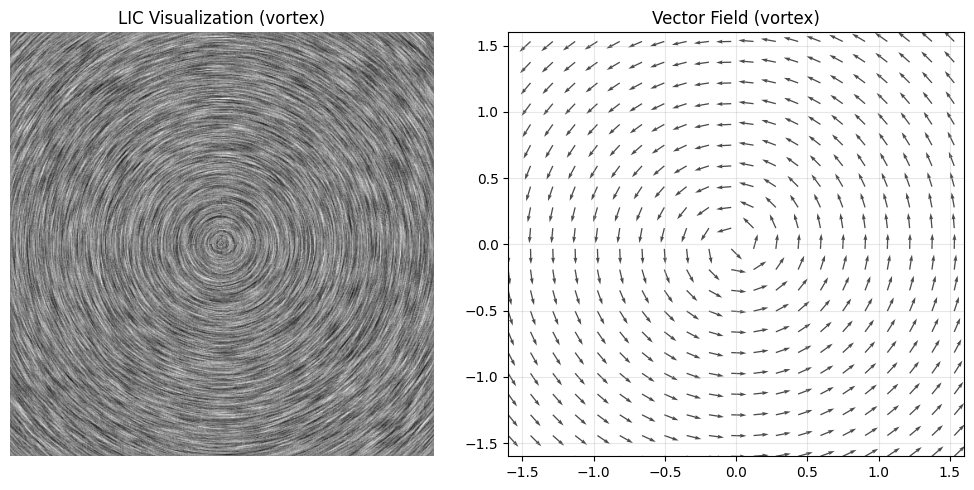


Both visualizations complete! You can experiment with different parameters:
- Adjust R (extent) to zoom in/out
- Adjust RES (resolution) for quality vs speed tradeoff
- Adjust length parameter for LIC integration length


In [37]:
# Compare analytic vortex vs loaded vector field
print("Rendering analytic vortex for comparison...")
lic_img_vortex = create_lic_visualization(mode='vortex', R=1.6, RES=512)

print("\nBoth visualizations complete! You can experiment with different parameters:")
print("- Adjust R (extent) to zoom in/out") 
print("- Adjust RES (resolution) for quality vs speed tradeoff")
print("- Adjust length parameter for LIC integration length")

In [35]:
import numpy as np
from PIL import Image, ImageDraw

# ------------- parameters -------------
W, H      = 4000, 4000          # canvas size
N_PART    = 10_000             # more particles = denser texture
STEPS     = 400                 # integration steps per particle
STEP_SIZE = 0.002               # ~ fraction of image width
ALPHA     = 2                   # 0-255 per stroke
BG        = 255                 # white background

# ------------- vector field -----------
def F(px, py):
    """Example: curl of Perlin-ish noise field (here a simple swirl)"""
    # map pixel → [-1,1] coords
    x = (px/W)*2 - 1
    y = (py/H)*2 - 1
    return -y, x      # simple vortex

# ------------- integrate --------------
img = Image.new("L", (W, H), BG)
drw = ImageDraw.Draw(img, "L")

rng = np.random.default_rng(0)
starts_x = rng.uniform(0, W,  N_PART)
starts_y = rng.uniform(0, H,  N_PART)

for x0, y0 in zip(starts_x, starts_y):
    x, y = x0, y0
    pts   = []
    for _ in range(STEPS):
        u, v = F(x, y)
        norm = (u*u + v*v)**0.5 + 1e-6
        x   += (u / norm) * STEP_SIZE * W
        y   += (v / norm) * STEP_SIZE * W
        if not (0 <= x < W and 0 <= y < H):
            break
        pts.append((x, y))
    if len(pts) > 1:
        drw.line(pts, fill=BG-ALPHA, width=1)   # low-alpha, additive

# img = img.filter(Image.BLUR)  # subtle blur like the example
img.save("flow_field.png")

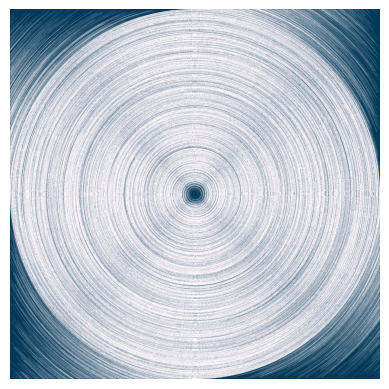

In [36]:
plt.imshow(img, cmap='PuBu', origin='lower')
plt.axis('off')
plt.show()